In [22]:
import torch
import torchvision

'''
This is another variant of the exercise 2 where the encoder returns
mu and log(std^2) instead of mu and std.
This is a more numerically stable way of doing it.

there is no need to call abs() on the output of the encoder since log(std^2) can
assume any value (while std was always positive)

to compute the actual std when sampling we need to compute exp(0.5*log(std^2))

exp(0.5*log(std^2)) =>exp(0.5*2*log(std)) => exp(log(std)) => std

So std is computed as exp(0.5*logvar) where logvar is the output of the encoder.

The KL-divergence is computed as:

0.5 * sum(std**2 + mu**2 - 1 - torch.log(std**2)

but since our encoder outputs logvar=log(std^2) we can rewrite it as:

0.5 * sum(logvar.exp() + mu**2 - 1 - logvar)
'''

train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
)


In [30]:
import torch
import torch.distributions as distributions

class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
        )

        self.mu_head = torch.nn.Linear(300, bottleneck_dim)
        self.logvar_head = torch.nn.Linear(300, bottleneck_dim)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, input_dim),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)

        mu = self.mu_head(x)
        logvar = self.logvar_head(x)

        return mu, logvar

    def generate(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        p = distributions.Normal(mu, std)
        z = p.rsample()

        return self.decoder(z)

    def forward(self, x, return_kl=False):
        mu, logvar = self.encode(x)
        reconstructed = self.generate(mu, logvar)
        
        if return_kl:
            kl = 0.5 * (logvar.exp() + mu**2 - 1 - logvar).sum(dim=1).mean(dim=0)
            return reconstructed, kl
        
        return reconstructed


model = VariationalAutoencoder(784, 10)
out, kl = model(torch.randn(5, 784), return_kl=True)
print(out.shape, kl)

torch.Size([5, 784]) tensor(0.1321, grad_fn=<MulBackward0>)


In [38]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
model = VariationalAutoencoder(784, 2).to("cuda")
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    bar = tqdm(dl)
    for digit, _ in bar:
        digit = digit.to("cuda")
        digit = digit.view(digit.shape[0], 28 * 28)
        recostructed, kl = model(digit, return_kl=True)
        error = loss_fn(recostructed, digit)

        loss = error + 0.005*kl
        bar.set_description(f"Loss: {loss.item():.2f} | Error: {error.item():.2f} | KL: {kl.item():.2}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Loss: 0.23 | Error: 0.21 | KL: 4.0: 100%|██████████| 1875/1875 [00:07<00:00, 242.74it/s] 
Loss: 0.22 | Error: 0.20 | KL: 4.0: 100%|██████████| 1875/1875 [00:07<00:00, 244.63it/s]
Loss: 0.20 | Error: 0.18 | KL: 4.4: 100%|██████████| 1875/1875 [00:07<00:00, 248.13it/s]


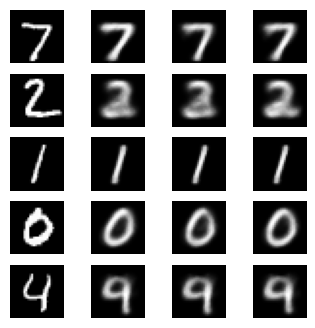

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 4, figsize=(4, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    mu, logvar = model.encode(digit)
    recostructed1 = model.generate(mu, logvar).cpu().detach().numpy().reshape(28, 28)
    recostructed2 = model.generate(mu, logvar).cpu().detach().numpy().reshape(28, 28)
    recostructed3 = model.generate(mu, logvar).cpu().detach().numpy().reshape(28, 28)

    axes[i][0].imshow(test_mnist[i][0].reshape(28, 28), cmap="gray")
    axes[i][1].imshow(recostructed1, cmap="gray")
    axes[i][2].imshow(recostructed2, cmap="gray")
    axes[i][3].imshow(recostructed3, cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")
    axes[i][2].axis("off")
    axes[i][3].axis("off")


plt.show()

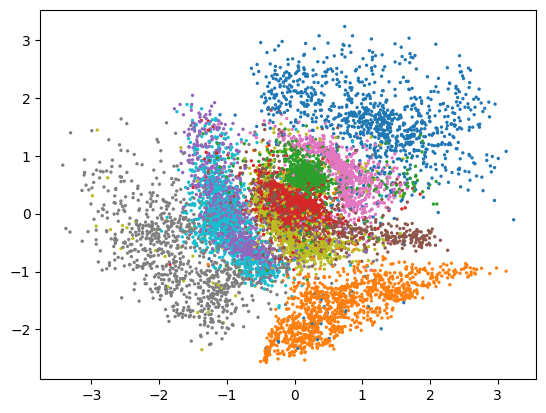

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
dl = torch.utils.data.DataLoader(test_mnist, batch_size=32)

for digit, cls in dl:
    digit = digit.view(-1, 28 * 28).to("cuda")
    mu, std = model.encode(digit)
    mu = mu.cpu().detach().numpy()

    ax.scatter(mu[:, 0], mu[:, 1], c=cls, cmap="tab10", s=2)

plt.show()

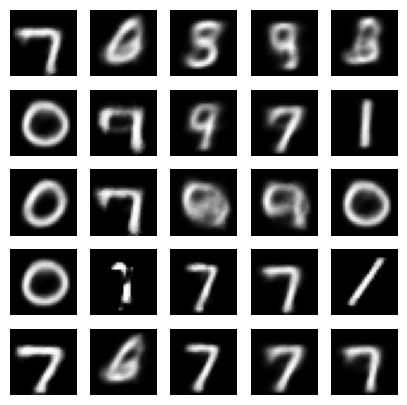

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

N = 5

fig, ax = plt.subplots(N, N, figsize=(N, N))

for i in range(N):
    for j in range(N):
        mu = torch.randn(1, 2).to("cuda")
        std = torch.randn(1, 2).to("cuda").abs()
        recostructed = model.generate(mu, std).cpu().detach().numpy().reshape(28, 28)
        ax[i][j].imshow(recostructed, cmap="gray")
        ax[i][j].axis("off")